In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Imports

In [5]:
# spaCy for Greek language handling
!python -m spacy download el_core_news_md
# pandarallel for faster applying of functions to dataframes. Need for tokens, lemmas etc.
!pip install unidecode
!pip install pandarallel
print("\n")
print("INSTALLATIONS COMPLETE.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 MB 26.4 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_md')


INSTALLATIONS COMPLETE.


In [14]:
import spacy
from pandarallel import pandarallel
from sklearn.linear_model import LogisticRegression
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,roc_curve
from matplotlib import pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import unicodedata as ud
from unidecode import unidecode
from sklearn.model_selection import GridSearchCV
import optuna
from scipy.sparse import hstack
import nltk

print('Imports done.')

Imports done.


## Data Pre-processing

In [172]:
nlp = spacy.load('el_core_news_md')
df = pd.read_csv('/kaggle/input/ys19-2023-assignment-1/train_set.csv')

df.head()

,New_ID,Text,Sentiment,Party
0,35027,#απολυμανση_κοριοι #απεντομωση_κοριος #απολυμα...,NEUTRAL,SYRIZA
1,9531,Έξι νέες επιστολές για τη Μακεδονία «καίνε» τη...,NEGATIVE,ND
2,14146,"Ισχυρό ΚΚΕ, δύναμη του λαού στη Βουλή και στου...",POSITIVE,KKE
3,28716,@five2nds @anthi7vas Μνημονιακότατο το #ΜεΡΑ25...,NEUTRAL,KKE
4,32886,@ai_katerina Αυτό που είναι συγκλονιστικό είνα...,NEUTRAL,SYRIZA


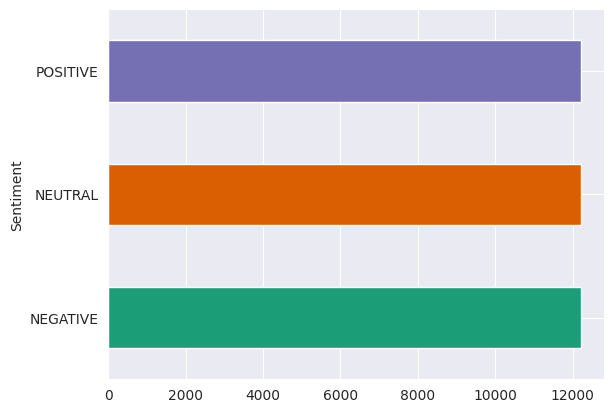

In [173]:
# Visualize our data (specifically the Sentiment column)
# Data Distribution

df.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: xlabel='Sentiment', ylabel='count'>

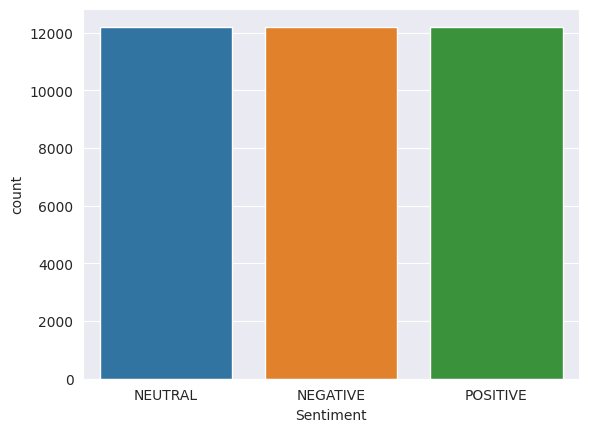

In [174]:
# Countplot for column Sentiment, Sentiment values are of the same number for each sentiment
sns.countplot(x='Sentiment',data=df)

<Axes: xlabel='Party', ylabel='count'>

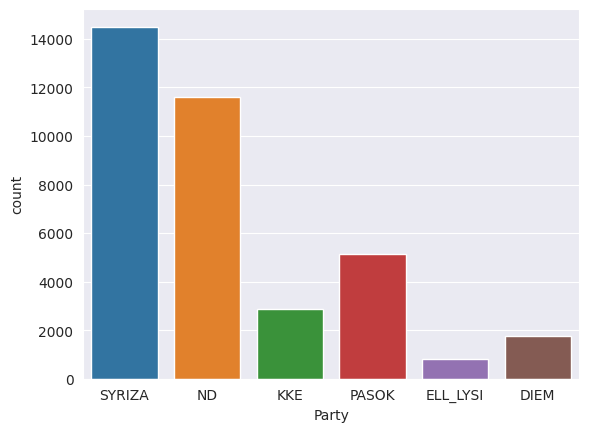

In [175]:
# Countplot for Parties , We can see that SYRIZA is the most prevalent party in the tweets dataset
sns.countplot(x='Party',data=df)

In [179]:
# Check for null values
df.isnull().sum()

# Create stop word list for word cloud and word frequency
stop_words = 'amp,αδιακοπα, αι, ακομα, ακομη, ακριβως, αληθεια, αληθινα, αλλα, αλλαχου, αλλες, αλλη, αλλην, αλλης, αλλιως, αλλιωτικα, αλλο, αλλοι, αλλοιως, αλλοιωτικα, αλλον, αλλος, αλλοτε, αλλου, αλλους, αλλων, αμα, αμεσα, αμεσως, αν, ανα, αναμεσα, αναμεταξυ, ανευ, αντι, αντιπερα, αντις, ανω, ανωτερω, αξαφνα, απ, απεναντι, απο, αποψε, αρα, αραγε, αργα, αργοτερο, αριστερα, αρκετα, αρχικα, ας, αυριο, αυτα, αυτες, αυτη, αυτην, αυτης, αυτο, αυτοι, αυτον, αυτος, αυτου, αυτους, αυτων, αφοτου, αφου, βεβαια, βεβαιοτατα, γι, για, γρηγορα, γυρω, δα, δε, δεινα, δεν, δεξια, δηθεν, δηλαδη, δι, δια, διαρκως, δικα, δικο, δικοι, δικος, δικου, δικους, διολου, διπλα, διχως, εαν, εαυτο, εαυτον, εαυτου, εαυτους, εαυτων, εγκαιρα, εγκαιρως, εγω, εδω, ειδεμη, ειθε, ειμαι, ειμαστε, ειναι, εις, εισαι, εισαστε, ειστε, ειτε, ειχα, ειχαμε, ειχαν, ειχατε, ειχε, ειχες, εκαστα, εκαστες, εκαστη, εκαστην, εκαστης, εκαστο, εκαστοι, εκαστον, εκαστος, εκαστου, εκαστους, εκαστων, εκει, εκεινα, εκεινες, εκεινη, εκεινην, εκεινης, εκεινο, εκεινοι, εκεινον, εκεινος, εκεινου, εκεινους, εκεινων, εκτος, εμας, εμεις, εμενα, εμπρος, εν, ενα, εναν, ενας, ενος, εντελως, εντος, εντωμεταξυ, ενω, εξ, εξαφνα, εξης, εξισου, εξω, επανω, επειδη, επειτα, επι, επισης, επομενως, εσας, εσεις, εσενα, εστω, εσυ, ετερα, ετεραι, ετερας, ετερες, ετερη, ετερης, ετερο, ετεροι, ετερον, ετερος, ετερου, ετερους, ετερων, ετουτα, ετουτες, ετουτη, ετουτην, ετουτης, ετουτο, ετουτοι, ετουτον, ετουτος, ετουτου, ετουτους, ετουτων, ετσι, ευγε, ευθυς, ευτυχως, εφεξης, εχει, εχεις, εχετε, εχθες, εχομε, εχουμε, εχουν, εχτες, εχω, εως, η, ηδη, ημασταν, ημαστε, ημουν, ησασταν, ησαστε, ησουν, ηταν, ητανε, ητοι, ηττον, θα, ι, ιδια, ιδιαν, ιδιας, ιδιες, ιδιο, ιδιοι, ιδιον, ιδιος, ιδιου, ιδιους, ιδιων, ιδιως, ιι, ιιι, ισαμε, ισια, ισως,κ,καθε, καθεμια, καθεμιας, καθενα, καθενας, καθενος, καθετι, καθολου, καθως, και, κακα, κακως, καλα, καλως, καμια, καμιαν, καμιας, καμποσα, καμποσες, καμποση, καμποσην, καμποσης, καμποσο, καμποσοι, καμποσον, καμποσος, καμποσου, καμποσους, καμποσων, κανεις, κανεν, κανενα, κανεναν, κανενας, κανενος, καποια, καποιαν, καποιας, καποιες, καποιο, καποιοι, καποιον, καποιος, καποιου, καποιους, καποιων, καποτε, καπου, καπως, κατ ,κατα, κατι, κατιτι, κατοπιν, κατω, κιολας,κι, κλπ, κοντα, κτλ, κυριως, λιγακι, λιγο, λιγωτερο, λογω, λοιπα, λοιπον, μα, μαζι, μακαρι, μακρυα, μαλιστα, μαλλον, μας, με, μεθαυριο, μειον, μελει, μελλεται, μεμιας, μεν, μερικα, μερικες, μερικοι, μερικους, μερικων, μεσα, μετ, μετα, μεταξυ, μεχρι, μη, μηδε, μην, μηπως, μητε, μια, μιαν, μιας, μολις, μολονοτι, μοναχα, μονες, μονη, μονην, μονης, μονο, μονοι, μονομιας, μονος, μονου, μονους, μονων, μου, μπορει, μπορουν, μπραβο, μπρος, να, ναι, νωρις, ξανα, ξαφνικα, ο, οι, ολα, ολες, ολη, ολην, ολης, ολο, ολογυρα, ολοι, ολον, ολονεν, ολος, ολοτελα, ολου, ολους, ολων, ολως, ολωσδιολου, ομως, οποια, οποιαδηποτε, οποιαν, οποιανδηποτε, οποιας, οποιασδηποτε, οποιδηποτε, οποιες, οποιεσδηποτε, οποιο, οποιοδηποτε, οποιοι, οποιον, οποιονδηποτε, οποιος, οποιοσδηποτε, οποιου, οποιουδηποτε, οποιους, οποιουσδηποτε, οποιων, οποιωνδηποτε, οποτε, οποτεδηποτε, οπου, οπουδηποτε, οπως, ορισμενα, ορισμενες, ορισμενων, ορισμενως, οσα, οσαδηποτε, οσες, οσεσδηποτε, οση, οσηδηποτε, οσην, οσηνδηποτε, οσης, οσησδηποτε, οσο, οσοδηποτε, οσοι, οσοιδηποτε, οσον, οσονδηποτε, οσος, οσοσδηποτε, οσου, οσουδηποτε, οσους, οσουσδηποτε, οσων, οσωνδηποτε, οταν, οτι, οτιδηποτε, οτου, ου, ουδε, ουτε, οχι, παλι, παντοτε, παντου, παντως, παρα, περα, περι, περιπου, περισσοτερο, περσι, περυσι, πια, πιθανον, πιο, πισω, πλαι, πλεον, πλην, ποια, ποιαν, ποιας, ποιες, ποιο, ποιοι, ποιον, ποιος, ποιου, ποιους, ποιων, πολυ, ποσες, ποση, ποσην, ποσης, ποσοι, ποσος, ποσους, ποτε, που, πουθε, πουθενα, πρεπει, πριν, προ, προκειμενου, προκειται, προπερσι, προς, προτου, προχθες, προχτες, πρωτυτερα, πως, σαν, σας, σε, σεις, σημερα, σιγα, σου, στα, στη, στην, στης, στις, στο, στον, στου, στους, στων, συγχρονως, συν, συναμα, συνεπως, συνηθως, συχνα, συχνας, συχνες, συχνη, συχνην, συχνης, συχνο, συχνοι, συχνον, συχνος, συχνου, συχνου, συχνους, συχνων, συχνως, σχεδον, σωστα, τα, ταδε, ταυτα, ταυτες, ταυτη, ταυτην, ταυτης, ταυτο,ταυτον, ταυτος, ταυτου, ταυτων, ταχα, ταχατε, τελικα, τελικως, τες, τετοια, τετοιαν, τετοιας, τετοιες, τετοιο, τετοιοι, τετοιον, τετοιος, τετοιου, τετοιους, τετοιων, τη, την, της, τι, τιποτα, τιποτε, τις, το, τοι, τον, τος, τοσα, τοσες, τοση, τοσην, τοσης, τοσο, τοσοι, τοσον, τοσος, τοσου, τοσους, τοσων, τοτε, του, τουλαχιστο, τουλαχιστον, τους, τουτα, τουτες, τουτη, τουτην, τουτης, τουτο, τουτοι, τουτοις, τουτον, τουτος, τουτου, τουτους, τουτων, τυχον, των, τωρα, υπ, υπερ, υπο, υποψη, υποψιν, υστερα, φετος, χαμηλα, χθες, χτες, χωρις, χωριστα, ψηλα, ω, ωραια, ως, ωσαν, ωσοτου, ωσπου, ωστε, ωστοσο, ωχ'


stop_words_separated = stop_words.split(",")
stop_words_separated = [w.strip() for w in stop_words_separated] # remove whitespaces

# remove diacritics
d = {ord('\N{COMBINING ACUTE ACCENT}'):None}

for word in stop_words_separated:
    word = ud.normalize('NFD',word).translate(d)

print('Stop words created.')

Stop words created.


In [196]:
# Data cleanup
# Remove all useless characters from tweets (URLs, Hashtags, mentions (at signs), punctuations)
# also removes mentioned accounts after hashtags and @ signs and special symbols.
def clean_tweet(tweet):
    '''
    Function to clean a tweet text by removing the links, punctuations, hashtags, mentions symbols and every text after mentions and hashtags
    using regex expressions. Also removes special symbols.
    Parameters:
       tweet (string): Tweet text to transform.
    Returns:
       tweet_cleaned (string): Tweet without links, punctuations, hashtags, ,mentions symbols and every text after mentions and hashtags. Also removes special symbols.
    """
    '''
    # convert the tweet text to lowercase letters
    tweet_lower = tweet.lower()
    # remove links, punctuations, hashtags, ,mentions and other symbols
    tweet_cleaned = re.sub(u"(http\S+)|([“”!?.»«,:;()\"%&-])|([#@]\S+)|", "", tweet_lower)
    
    return tweet_cleaned

# Apply function to all tweets (text column)
df['Text'] = [clean_tweet(tweet) for tweet in df['Text']]

def find_english_words(text):
    return re.findall(r'\b[a-zA-Z]+\b', text)

english_words = [find_english_words(text) for text in df['Text']]
eng_word_sep = [(",").join(word) for word in english_words]



# remove diacritics from Text column
text_no_diacritics = []
d = {ord('\N{COMBINING ACUTE ACCENT}'):None}
for tweet in df['Text']:
    text1 = ud.normalize('NFD',tweet).translate(d)
    text_no_diacritics.append(text1)

df['Text'] = text_no_diacritics

# Remove stop_words from text column
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_separated)]))

print(df['Text']) # making sure the cleanup works.

# Using pandarallel for faster tokenization and lemmatization.
# pandarallel.initialize(progress_bar=True)

# I added comments to these columns as they took a considerable amount of time to be finished , and they're not usable
# since they produce worse results.
# df['Docs'] = df['Text'].parallel_apply(lambda x: nlp(x)) # add docs to dataframe in order to get tokens
# df['Lemmas'] = df['Text'].parallel_apply(lambda row: " ".join([w.lemma_ for w in nlp(row)])) # add lemmas to dataframe
print("Text cleanup complete.")

0        κυριακη κοριοι απολυμανση καταπολεμηση κοριων ...
1        εξι νεες επιστολες μακεδονια καινε νδ μητσοτακ...
2         ισχυρο κκε δυναμη λαου βουλη καθημερινους αγωνες
3                                           μνημονιακοτατο
4                         συγκλονιστικο ψυχασθενεια τσιπρα
                               ...                        
36625    κουλης μητσοτακης λεει ψεματαδεν αδειασε μπαμπ...
36626    προσεξε σκισει καλσον χαλια νεα φωτογραφια ομο...
36627    θεση κκε ασφαλεια πολιτων διαφορους ρουβικωνες...
36628    μαρη κακομοιρα θυγατερα ναζιστη αντισημιτη ξεφ...
36629                              ενταξει επεισες κκε 🤘❤️
Name: Text, Length: 36630, dtype: object
Text cleanup complete.


In [225]:
eng_word_sep = [(",").join(word) for word in english_words]
def lists_to_string_skip_empty(list_of_lists):
   # Flatten the list of lists, skipping empty lists
   flat_list = [item for sublist in list_of_lists if sublist for item in sublist]
   # Convert the flat list to a comma-separated string
   return ', '.join(flat_list)

eng_word_sep_no_empty = [item for item in eng_word_sep if item != '']
eng_word_no_dupes = list(set(eng_word_sep_no_empty))
# final_list = lists_to_string_skip_empty(eng_word_sep)
# print(english_words)
print(eng_word_sep)
# print(final_list)

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'news', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'newsbomb', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

In [197]:
# Creating some visualizations with tokens
# Word cloud
tweets = []
for tweet in df['Text']:
    #tokens.append(doc.text)
    tweets.append(tweet)
    
print(len(tweets))
print(stop_words_separated)

# stop_words = stopwords.words('greek')
for i in range(len(tweets)):
        tweets[i] = tweets[i].lower()


# remove Diacritics in Greek (tonous)
d = {ord('\N{COMBINING ACUTE ACCENT}'):None}
tweets_string = "".join(tweets)
tweets_without_accent = ud.normalize('NFD',tweets_string).translate(d)
    
print(type(tweets_without_accent))

wordcloud = WordCloud(stopwords=stop_words_separated).generate(str(tweets_without_accent))
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

36630
['amp', 'αδιακοπα', 'αι', 'ακομα', 'ακομη', 'ακριβως', 'αληθεια', 'αληθινα', 'αλλα', 'αλλαχου', 'αλλες', 'αλλη', 'αλλην', 'αλλης', 'αλλιως', 'αλλιωτικα', 'αλλο', 'αλλοι', 'αλλοιως', 'αλλοιωτικα', 'αλλον', 'αλλος', 'αλλοτε', 'αλλου', 'αλλους', 'αλλων', 'αμα', 'αμεσα', 'αμεσως', 'αν', 'ανα', 'αναμεσα', 'αναμεταξυ', 'ανευ', 'αντι', 'αντιπερα', 'αντις', 'ανω', 'ανωτερω', 'αξαφνα', 'απ', 'απεναντι', 'απο', 'αποψε', 'αρα', 'αραγε', 'αργα', 'αργοτερο', 'αριστερα', 'αρκετα', 'αρχικα', 'ας', 'αυριο', 'αυτα', 'αυτες', 'αυτη', 'αυτην', 'αυτης', 'αυτο', 'αυτοι', 'αυτον', 'αυτος', 'αυτου', 'αυτους', 'αυτων', 'αφοτου', 'αφου', 'βεβαια', 'βεβαιοτατα', 'γι', 'για', 'γρηγορα', 'γυρω', 'δα', 'δε', 'δεινα', 'δεν', 'δεξια', 'δηθεν', 'δηλαδη', 'δι', 'δια', 'διαρκως', 'δικα', 'δικο', 'δικοι', 'δικος', 'δικου', 'δικους', 'διολου', 'διπλα', 'διχως', 'εαν', 'εαυτο', 'εαυτον', 'εαυτου', 'εαυτους', 'εαυτων', 'εγκαιρα', 'εγκαιρως', 'εγω', 'εδω', 'ειδεμη', 'ειθε', 'ειμαι', 'ειμαστε', 'ειναι', 'εις', 'εισαι',

AttributeError: 'list' object has no attribute 'lower'

κουλης μητσοτακης λεει ψεματαδεν αδειασε μπαμπη παπαδημητριουο μπαμπης προετοιμαζει ερχεται κουλη μητσοτακηξαφαστουρναρα4 μνημονιο επιστροφη μεσαιωνα
προσεξε σκισει καλσον χαλια νεα φωτογραφια ομορφη πραγματικοτητα
μαρη κακομοιρα θυγατερα ναζιστη αντισημιτη ξεφτιλιστει τρολ νδ σχολιαζουν ντροπη μπορεις παντα λιποθυμησεις ναζιστες φιλοι


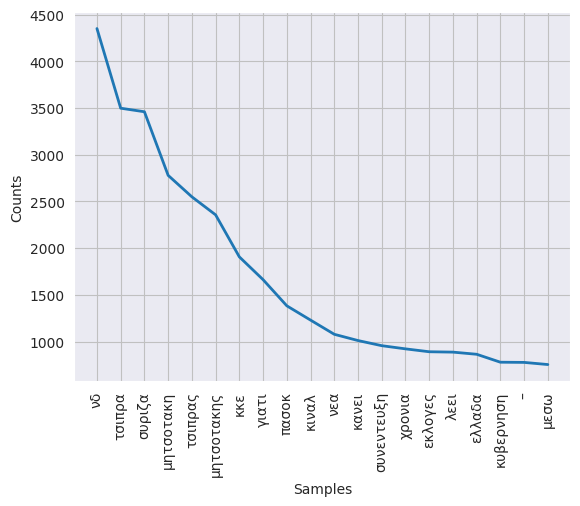

In [184]:
# Tokens frequency diagram
tokens = nltk.word_tokenize(tweets_without_accent)
  

print(df['Text'][36625])
print(df['Text'][36626])
print(df['Text'][36628])


sns.set_style('darkgrid')
nlp_words=nltk.FreqDist(tokens)
nlp_words.plot(20);

In [198]:
# X = df['Lemmas'] # Lemma as feature, doesn't really increase performance of f1-score.
# X = df['Tokens'] # same as above for tokens.
X = df['Text'] # 38% f1-score , best feature as of yet

# vectorizer = TfidfVectorizer()
# X_text_encoded = vectorizer.fit_transform(df['Text'])
# X_party_encoded = pd.get_dummies(df['Party'])
# X = hstack((X_text_encoded, X_party_encoded)) # 37.5% f1-score using both text and party as features

y = df['Sentiment'] # label

print("X shape:", X.shape)
print("y shape:", y.shape)

# Apply cross validation for our model
# 70% training data 30% test data is optimal for our case.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# use TF-IDF Vectorizer to make text into vectors
# we have an increase of 0.01% with TF-IDF instead of CountVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

print("Cross validation complete.")

X shape: (36630,)
y shape: (36630,)
Cross validation complete.


## Model training

In [146]:
# create and train our Logistic Regression model
# by making tests I figured out that LBFGS solver is the best as it gives the best metrics overall.

lr_model = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_model.fit(X_train, y_train)

# add predictions to list.
predictions = lr_model.predict(X_test)
print(predictions.shape)
print("Model training complete.")

# average f1 score using vectorized X = 38% for all sentiments
# average brute force f1 score = 37.8% for all sentiments

(10989,)
Model training complete.


## Optuna hyperparameter tuning

In [216]:
def objective(trial , X = X , y = y):
    X_train, X_test, y_train, y_test = train_test_split(X , y , \
            test_size = 0.3)    
    params = {
        'tol' : trial.suggest_float('tol' , 1e-6 , 1e-3),
        'C' : trial.suggest_float("C", 1e-2, 1,log=True),
       # 'fit_intercept' : trial.suggest_categorical('fit_intercept' , [True, False]),
        # 'random_state' : trial.suggest_categorical('random_state' , [0, 42, 2021, 555]),
        # 'solver' : trial.suggest_categorical('solver' , ['lbfgs','liblinear']),
        "n_jobs" : -1,
        "max_iter": 1000
    }
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    model1 = LogisticRegression(**params)
    model1.fit(X_train , y_train)
    y_predlr1 = model1.predict(X_test)
    f1 = f1_score(y_test,y_predlr1,average='micro')
    return f1
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
study = optuna.create_study(direction = 'minimize' , study_name = 'lr'
                            , pruner = optuna.pruners.HyperbandPruner() 
                           )
study.optimize(objective, n_trials = 500)
print('numbers of the finished trials:' , len(study.trials))
print('the best params:' , study.best_trial.params)
print('the best value:' , study.best_value)

[W 2023-11-07 14:13:42,386] Trial 231 failed with parameters: {'tol': 0.00027218201933428725, 'C': 0.03392933061933227} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_32/1343786041.py", line 18, in objective
    model1.fit(X_train , y_train)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/opt/conda/lib/python3.10/site-packages/joblib/parallel.py", line 1952, in __call__
    return output if self.return_generator else list(output)
  File "/opt/conda/lib/python3.10/site-packages/joblib/parallel.py", line

KeyboardInterrupt: 

In [212]:
# Train model with best hyperparameter values
lr_model = LogisticRegression(solver='lbfgs',max_iter=1000,tol=0.0007294770991206959,C=0.06169882722761676,n_jobs=-1) # 39%, best hyperparams
# lr_model = LogisticRegression(solver='lbfgs',max_iter=1000,tol=0.0005274304403229184,C=0.7116038524705507,n_jobs=-1)
lr_model.fit(X_train, y_train) # best possible outcome for now: 39%

# add predictions to list.
predictions = lr_model.predict(X_test)
print(predictions.shape)
print("Model training complete.")

(10989,)
Model training complete.


## Model evaluation and plots

In [213]:
# use Validation set for metrics
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

    NEGATIVE       0.38      0.50      0.43      3642
     NEUTRAL       0.39      0.31      0.34      3705
    POSITIVE       0.41      0.36      0.38      3642

    accuracy                           0.39     10989
   macro avg       0.39      0.39      0.39     10989
weighted avg       0.39      0.39      0.39     10989



In [214]:
print("accuracy: ",accuracy_score(y_test,predictions))
print("f1: ",f1_score(y_test,predictions,average='micro'))
print("total f1: ",f1_score(y_test,predictions,average=None))

accuracy:  0.3891163891163891
f1:  0.3891163891163891
total f1:  [0.42911422 0.34450624 0.3833116 ]


In [215]:
print(confusion_matrix(y_test,predictions))

[[1807  948  887]
 [1508 1146 1051]
 [1465  854 1323]]


In [ ]:
# ROC Curve
# FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
# FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
# TP = np.diag(confusion_matrix)
# TN = confusion_matrix.values.sum() - (FP + FN + TP)

print('yolo')
# print(roc_curve(y_test,pred_proba))

## Output file

In [ ]:
import csv

with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(["Id","Predicted"])
    for i in range(1,10471):
        writer.writerow([i,predictions[i]])
        
        

    
print("CSV file writing complete.")